In [1]:
import logging
import os
from pprint import pprint

import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path

import helpers

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s\n%(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [4]:
logging.getLogger("gcsfs").setLevel("DEBUG")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("helpers").setLevel("DEBUG")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test debug-level message")

2022-07-07 16:01:13,407 87158/MainThread __main__ DEBUG
test debug-level message


### TCGA SKCM (real) bulk rna-seq

In [6]:
uri_tcga_skcm_bulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures_real_tcga_skcm/tpm.parquet"
)

In [7]:
!gsutil ls -lh $uri_tcga_skcm_bulk_rnaseq

 45.23 MiB  2022-05-26T05:32:00Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet
TOTAL: 1 objects, 47427179 bytes (45.23 MiB)


In [8]:
ddf_tcga_skcm_bulk_rnaseq = dd.read_parquet(uri_tcga_skcm_bulk_rnaseq, engine="pyarrow")
logger.debug(ddf_tcga_skcm_bulk_rnaseq.dtypes)

2022-07-07 16:01:15,311 87158/MainThread google.auth._default WARNING
No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2022-07-07 16:01:15,313 87158/MainThread gcsfs.credentials DEBUG
Connected with method google_default
2022-07-07 16:01:15,315 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 16:01:15,315 87158/fsspecIO gcsfs.credentials DEBUG
GCS refresh
2022-07-07 16:01:15,717 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 16:01:15,861 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 16:01:16,007 87158/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab

### pseudo bulk rna-seq

In [9]:
uri_pseudobulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet"
)

In [10]:
!gsutil ls -lh $uri_pseudobulk_rnaseq

 39.95 MiB  2022-05-26T05:33:49Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet
TOTAL: 1 objects, 41894774 bytes (39.95 MiB)


In [11]:
ddf_pseudobulk_rnaseq = (
    dd.read_parquet(
        uri_pseudobulk_rnaseq,
        engine="pyarrow",
    )
    .replace({"malignant_from_one_sample": {"True": True, "False": False}})
    .astype({"n_cells": "uint8", "malignant_from_one_sample": "bool"})
    .rename(columns={"tcga_aliquot_barcode_for_fractions": "aliquot_barcode"})
)

logger.debug(ddf_pseudobulk_rnaseq.dtypes)

2022-07-07 16:01:17,860 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 16:01:18,024 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 16:01:18,187 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 16:01:18,391 87158/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures%2Fn_cells=5%2Fmalignant_from_one_sample=True%2Fdata.parquet?alt=media, (), {'Range': 'bytes=41829238-41894773'}
2022-07-07 16:01:18,565 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtur

### analysis

In [12]:
# merge real and pseudo data
ddf_bulk_rnaseq_all = ddf_tcga_skcm_bulk_rnaseq.merge(
    ddf_pseudobulk_rnaseq,
    on=["aliquot_barcode", "gene_symbol"],
    how="inner",
    suffixes=["_tcga_skcm", "_pseudo"],
)

In [13]:
ddf_bulk_rnaseq_all

,gene_symbol,aliquot_barcode,tpm_tcga_skcm,tpm_pseudo,n_cells,malignant_from_one_sample
npartitions=1,,,,,,
,category[unknown],category[unknown],float64,float64,uint8,bool
,...,...,...,...,...,...


#### determine immune high and low

In [14]:
# load cell type fractions
df_tcga_skcm_fractions_from_csx = helpers.datasets.load_tcga_skcm_fractions_from_csx()

2022-07-07 16:01:19,099 87158/MainThread helpers.datasets DEBUG
loading TCGA SKCM fractions estimated by CIBERSORTx
2022-07-07 16:01:19,103 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'downloaded_manually/derek_csx_tcga_skcm/CIBERSORTx_Job8_Results.txt'), None
2022-07-07 16:01:19,263 87158/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/downloaded_manually%2Fderek_csx_tcga_skcm%2FCIBERSORTx_Job8_Results.txt?alt=media, (), {'Range': 'bytes=0-86860'}


In [15]:
# create immune fraction value for each sample
immune_cell_types = ["B", "Macrophage", "NK", "T", "T CD4", "T CD8"]

df_immune_fraction_by_aliquot_barcode = (
    df_tcga_skcm_fractions_from_csx[immune_cell_types]
    .sum(axis="columns")
    .rename("immune_fraction")
    .to_frame()
)

In [16]:
df_immune_fraction_by_aliquot_barcode

,immune_fraction
sample_id,
TCGA-3N-A9WB-06A-11R-A38C-07,0.006247
TCGA-3N-A9WC-06A-11R-A38C-07,0.269736
TCGA-3N-A9WD-06A-11R-A38C-07,0.119879
TCGA-BF-A1PU-01A-11R-A18S-07,0.023436
TCGA-BF-A1PV-01A-11R-A18U-07,0.013171
...,...
TCGA-YG-AA3O-06A-11R-A38C-07,0.042878
TCGA-YG-AA3P-06A-11R-A38C-07,0.027623
TCGA-Z2-A8RT-06A-11R-A37K-07,0.092170


In [17]:
# join these fractions onto bulk rna-seq data

ddf_bulk_rnaseq_all_with_immune = ddf_bulk_rnaseq_all.merge(
    df_immune_fraction_by_aliquot_barcode,
    left_on="aliquot_barcode",
    right_on="sample_id",
)

ddf_bulk_rnaseq_all_with_immune

,gene_symbol,aliquot_barcode,tpm_tcga_skcm,tpm_pseudo,n_cells,malignant_from_one_sample,immune_fraction
npartitions=1,,,,,,,
,category[unknown],object,float64,float64,uint8,bool,float64
,...,...,...,...,...,...,...


In [18]:
# compute immune high and low
immune_threshold_low = ddf_bulk_rnaseq_all_with_immune["immune_fraction"].quantile(0.2)
immune_threshold_high = ddf_bulk_rnaseq_all_with_immune["immune_fraction"].quantile(0.8)

In [19]:
immune_threshold_low, immune_threshold_high

(dd.Scalar<quantil..., dtype=float64>, dd.Scalar<quantil..., dtype=float64>)

In [20]:
ddf_bulk_rnaseq_all_with_immune["immune_low"] = (
    ddf_bulk_rnaseq_all_with_immune["immune_fraction"] <= immune_threshold_low
)

ddf_bulk_rnaseq_all_with_immune["immune_high"] = (
    ddf_bulk_rnaseq_all_with_immune["immune_fraction"] >= immune_threshold_high
)

In [21]:
df_bulk_rnaseq_all_with_immune = ddf_bulk_rnaseq_all_with_immune.compute()

2022-07-07 16:01:19,850 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 16:01:19,851 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 16:01:19,990 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 16:01:20,056 87158/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=47361643-47427178'}
2022-07-07 16:01:20,144 87158/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet')

In [22]:
df_bulk_rnaseq_all_with_immune["aliquot_barcode"].value_counts()

TCGA-3N-A9WB-06A-11R-A38C-07    16063
TCGA-ER-A2NF-06A-11R-A18T-07    16063
TCGA-FR-A3YN-06A-11R-A239-07    16063
TCGA-ER-A42L-06A-11R-A24X-07    16063
TCGA-ER-A42K-06A-11R-A24X-07    16063
                                ...  
TCGA-EE-A17X-06A-11R-A18S-07    16063
TCGA-EB-A6L9-06A-11R-A32P-07    16063
TCGA-EB-A5VV-06A-11R-A32P-07    16063
TCGA-EB-A5UN-06A-11R-A311-07    16063
TCGA-Z2-AA3V-06A-11R-A39D-07    16063
Name: aliquot_barcode, Length: 368, dtype: int64

In [23]:
df_bulk_rnaseq_all_with_immune[["immune_low", "immune_high"]].value_counts()

immune_low  immune_high
False       False          3533860
            True           1188662
True        False          1188662
dtype: int64

#### compute stats for each gene

In [24]:
### compute p-values...


def compute_stats(df):
    immune_low = df[df["immune_low"]]
    immune_high = df[df["immune_high"]]
    pval_pseudo = scipy.stats.mannwhitneyu(
        immune_high["tpm_pseudo"].values, immune_low["tpm_pseudo"].values
    )[1]
    neglog10pval_pseudo = -np.log10(pval_pseudo)
    foldchange_pseudo = (
        immune_high["tpm_pseudo"].mean() / immune_low["tpm_pseudo"].mean()
    )
    log2foldchange_pseudo = np.log2(foldchange_pseudo)

    pval_real = scipy.stats.mannwhitneyu(
        immune_high["tpm_tcga_skcm"].values, immune_low["tpm_tcga_skcm"].values
    )[1]
    neglog10pval_real = -np.log10(pval_real)
    foldchange_real = (
        immune_high["tpm_tcga_skcm"].mean() / immune_low["tpm_tcga_skcm"].mean()
    )
    log2foldchange_real = np.log2(foldchange_real)

    return pd.Series(
        dict(
            pval_pseudo=pval_pseudo,
            foldchange_pseudo=foldchange_pseudo,
            log2foldchange_pseudo=log2foldchange_pseudo,
            neglog10pval_pseudo=neglog10pval_pseudo,
            signedneglog10pval_pseudo=(
                neglog10pval_pseudo * np.sign(log2foldchange_pseudo)
            ),
            pval_real=pval_real,
            foldchange_real=foldchange_real,
            log2foldchange_real=log2foldchange_real,
            neglog10pval_real=neglog10pval_real,
            signedneglog10pval_real=(neglog10pval_real * np.sign(log2foldchange_real)),
        )
    )


df_gene_stats_by_immune = df_bulk_rnaseq_all_with_immune.groupby("gene_symbol").apply(
    compute_stats
)
df_gene_stats_by_immune = df_gene_stats_by_immune.reset_index()

In [25]:
df_gene_stats_by_immune

,gene_symbol,pval_pseudo,foldchange_pseudo,log2foldchange_pseudo,neglog10pval_pseudo,signedneglog10pval_pseudo,pval_real,foldchange_real,log2foldchange_real,neglog10pval_real,signedneglog10pval_real
0,A1BG,6.412492e-01,0.720147,-0.473636,0.192973,-0.192973,2.760504e-03,0.749164,-0.416646,2.559012,-2.559012
1,A2M,3.167108e-03,1.271063,0.346036,2.499337,2.499337,2.658208e-03,1.324988,0.405979,2.575411,2.575411
2,A2ML1,4.388290e-08,1.814381,0.859477,7.357705,7.357705,7.338630e-02,2.437467,1.285382,1.134385,1.134385
3,A4GALT,3.338668e-07,2.891020,1.531578,6.476427,6.476427,1.673329e-09,2.291428,1.196247,8.776419,8.776419
4,A4GNT,1.105002e-01,0.711084,-0.491909,0.956637,-0.956637,5.205548e-01,1.056338,0.079072,0.283534,0.283534
...,...,...,...,...,...,...,...,...,...,...,...
16058,ZYG11A,9.151915e-13,1.830013,0.871854,12.038488,12.038488,1.032366e-06,1.179268,0.237892,5.986166,5.986166
16059,ZYG11B,2.335214e-04,1.296229,0.374321,3.631673,3.631673,2.216201e-02,0.852496,-0.230235,1.654391,-1.654391
16060,ZYX,2.012901e-10,1.778343,0.830534,9.696178,9.696178,1.142813e-09,1.302782,0.381596,8.942025,8.942025
16061,ZZEF1,1.286925e-05,1.578373,0.658438,4.890447,4.890447,5.900124e-01,1.006465,0.009297,0.229139,0.229139


In [26]:
# how many genes have valid stats?

logger.debug(df_gene_stats_by_immune["pval_pseudo"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["foldchange_pseudo"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["pval_real"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["foldchange_real"].isna().value_counts())

2022-07-07 16:01:46,279 87158/MainThread __main__ DEBUG
False    16063
Name: pval_pseudo, dtype: int64
2022-07-07 16:01:46,280 87158/MainThread __main__ DEBUG
False    16054
True         9
Name: foldchange_pseudo, dtype: int64
2022-07-07 16:01:46,281 87158/MainThread __main__ DEBUG
False    16063
Name: pval_real, dtype: int64
2022-07-07 16:01:46,282 87158/MainThread __main__ DEBUG
False    16063
Name: foldchange_real, dtype: int64


In [48]:
import plotly.express as px

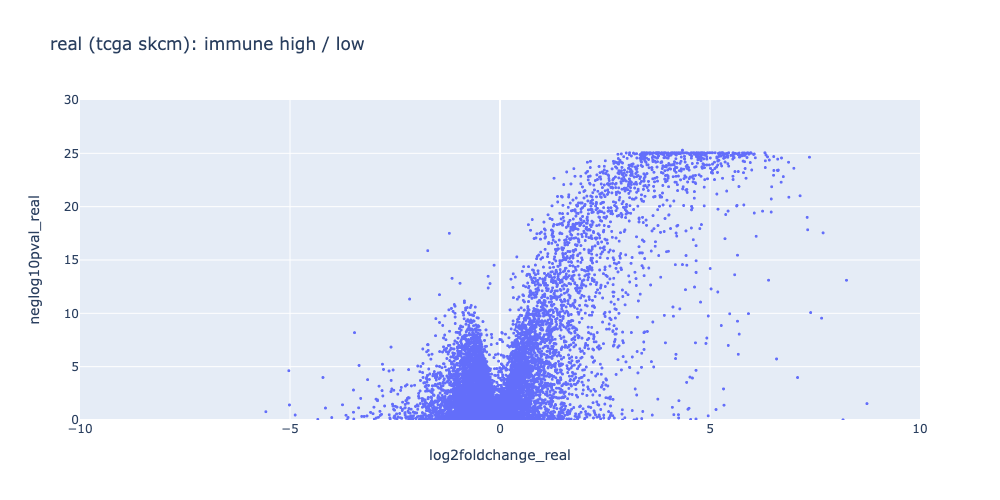

In [49]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="log2foldchange_real",
    y="neglog10pval_real",
    title="real (tcga skcm): immune high / low",
    hover_name="gene_symbol",
    hover_data=["foldchange_real", "pval_real"],
)
fig.update_xaxes(range=(-10, 10))
fig.update_yaxes(range=(0, 30))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=1, width=1000, height=500)

In [50]:
fig.show(renderer="browser")

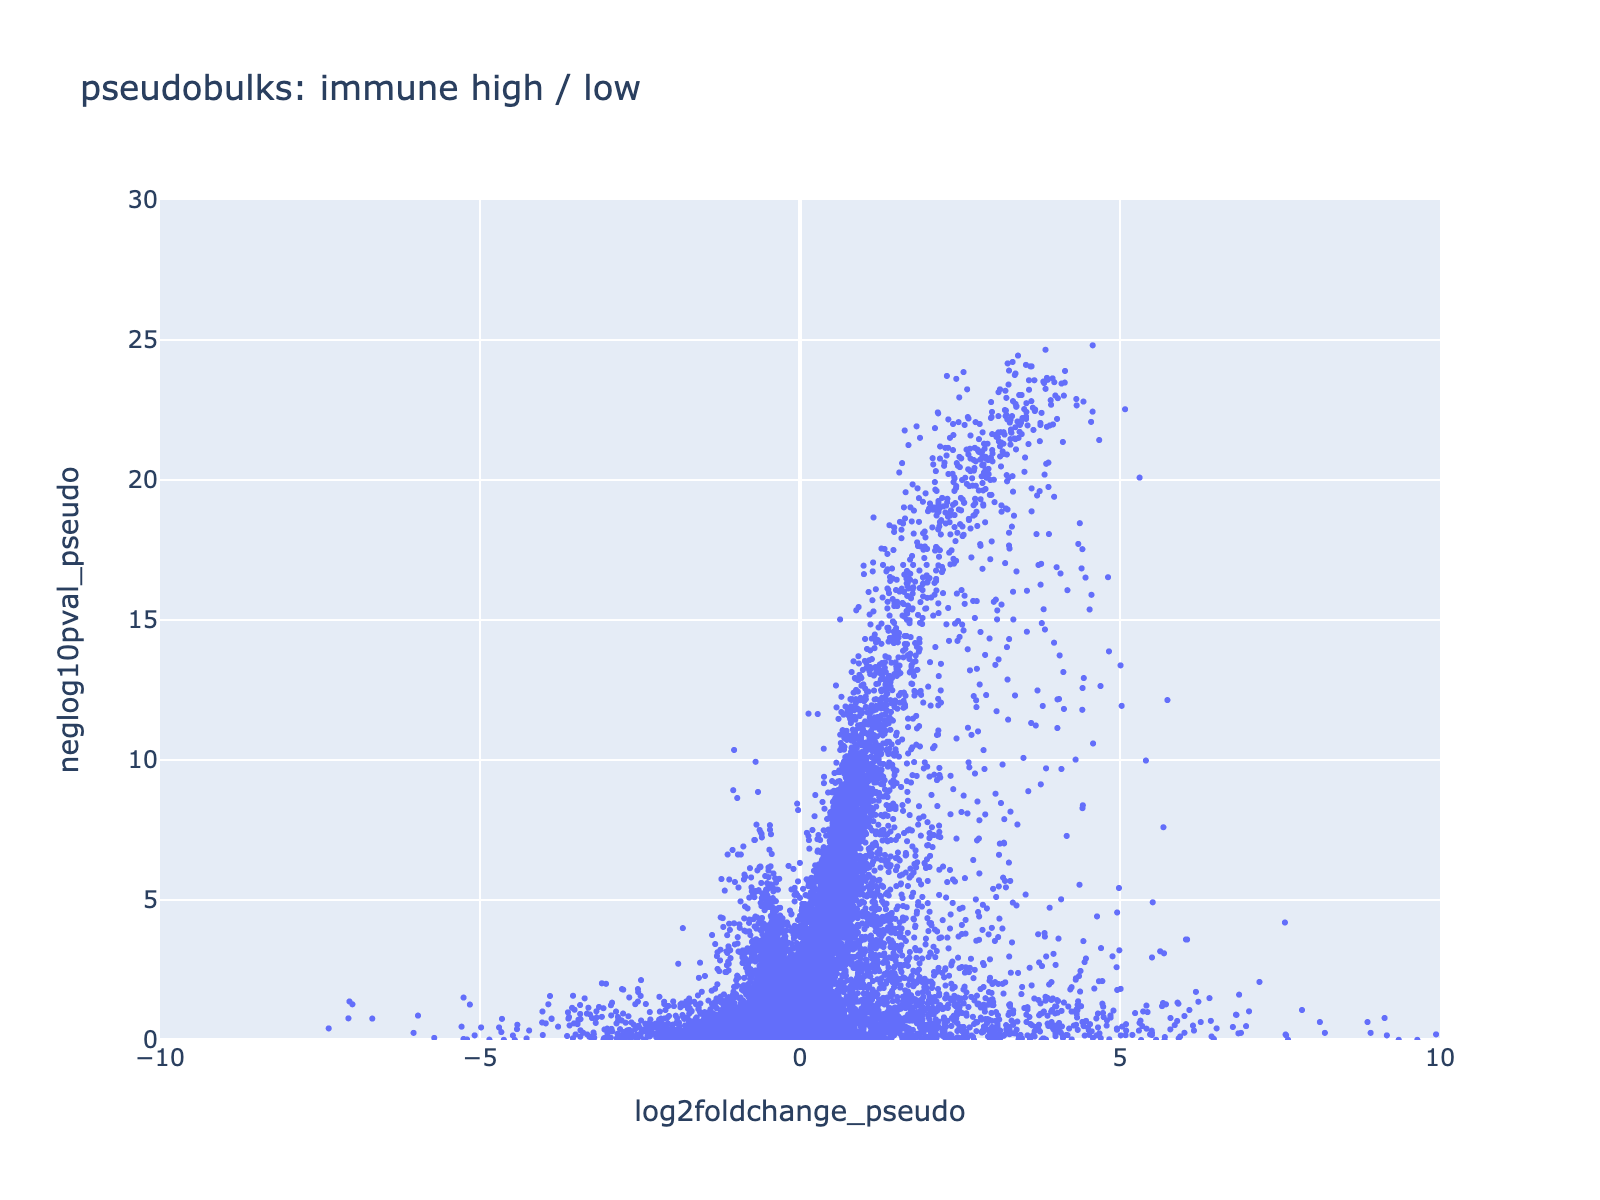

In [51]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="log2foldchange_pseudo",
    y="neglog10pval_pseudo",
    title="pseudobulks: immune high / low",
    hover_name="gene_symbol",
    hover_data=["foldchange_pseudo", "pval_pseudo"],
)
fig.update_xaxes(range=(-10, 10))
fig.update_yaxes(range=(0, 30))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=2, width=800, height=600)

In [52]:
fig.show(renderer="browser")

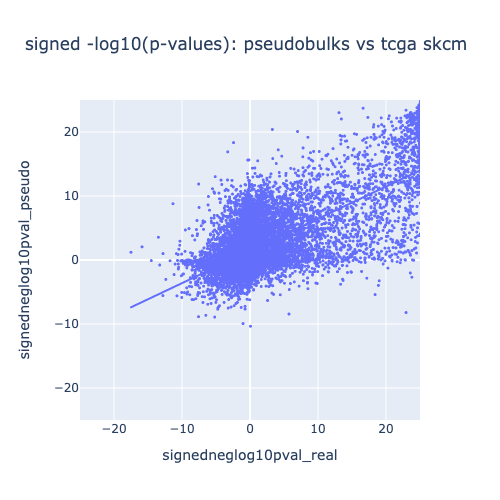

In [53]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="signedneglog10pval_real",
    y="signedneglog10pval_pseudo",
    trendline="ols",
    title="signed -log10(p-values): pseudobulks vs tcga skcm",
    hover_name="gene_symbol",
    hover_data=["log2foldchange_real", "log2foldchange_pseudo"],
)
fig.update_xaxes(range=(-25, 25))
fig.update_yaxes(range=(-25, 25))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=1, width=500, height=500)

In [54]:
fig.show(renderer="browser")

#### what's the overlap for significant genes between real, pseudo?

In [34]:
df_gene_stats_by_immune["percentile_neglog10pval_pseudo"] = df_gene_stats_by_immune[
    "neglog10pval_pseudo"
].rank(pct=True)
df_gene_stats_by_immune["percentile_neglog10pval_real"] = df_gene_stats_by_immune[
    "neglog10pval_real"
].rank(pct=True)

In [35]:
THRESHOLD = 0.8

df_gene_stats_by_immune["top_pseudo"] = (
    df_gene_stats_by_immune["percentile_neglog10pval_pseudo"] > THRESHOLD
)
df_gene_stats_by_immune["top_real"] = (
    df_gene_stats_by_immune["percentile_neglog10pval_real"] > THRESHOLD
)
df_gene_stats_by_immune["top_both"] = (
    df_gene_stats_by_immune["top_pseudo"] & df_gene_stats_by_immune["top_real"]
)
pd.crosstab(df_gene_stats_by_immune["top_pseudo"], df_gene_stats_by_immune["top_real"])

top_real,False,True
top_pseudo,,
False,11220,1632
True,1627,1584


In [36]:
# is it the same genes that showed up in the PCA analysis?